In [30]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import os

In [2]:
# dataset_dir = "../dataset_output/libras_minds/imgs/"
train_dir = "../dataset_output/libras_ufop/imgs_lopo/train/"
test_dir = "../dataset_output/libras_ufop/imgs_lopo/test/"
validate_dir = "../dataset_output/libras_ufop/imgs_lopo/validate/"

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Load dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
validate_dataset = datasets.ImageFolder(root=validate_dir, transform=transform)

In [5]:
# # Split dataset into train and test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [6]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)

In [119]:
# Load pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [120]:
num_ftrs = resnet.fc.in_features

In [121]:
num_features = len(os.listdir(train_dir))

In [49]:
# Modify the fully connected layer to match the number of classes
resnet.fc = nn.Linear(num_ftrs, num_features)

In [122]:
# Add an extra dense layer
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_features)
)

In [123]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=10e-5)
# optimizer = optim.Adam(resnet.parameters(), lr=10e-5, weight_decay=1e-5)

In [124]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [125]:
from datetime import datetime

In [126]:
epochs = 15
history = {"loss": [], "accuracy": []}
best_val_loss = float('inf')
best_model_weights = resnet.state_dict()
patience = 5
counter = 0
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        val_loss = criterion(outputs, labels)
        history["loss"].append(float(loss))
        history["accuracy"].append(float(accuracy))
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = resnet.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break

    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")
    print(str(datetime.now()))

Epoch 1/15, Loss: 2.6395, Val Accuracy: 0.6650
2024-03-24 21:58:53.313586
Epoch 2/15, Loss: 1.0539, Val Accuracy: 0.7800
2024-03-24 21:59:19.579288
Epoch 3/15, Loss: 0.5152, Val Accuracy: 0.8200
2024-03-24 21:59:46.875605
Epoch 4/15, Loss: 0.2920, Val Accuracy: 0.8350
2024-03-24 22:00:09.859559
Epoch 5/15, Loss: 0.1935, Val Accuracy: 0.8467
2024-03-24 22:00:33.772358
Epoch 6/15, Loss: 0.1369, Val Accuracy: 0.8533
2024-03-24 22:00:57.732017
Epoch 7/15, Loss: 0.1017, Val Accuracy: 0.8550
2024-03-24 22:01:21.718723
Epoch 8/15, Loss: 0.0831, Val Accuracy: 0.8583
2024-03-24 22:01:44.618750
Epoch 9/15, Loss: 0.0671, Val Accuracy: 0.8583
2024-03-24 22:02:07.738405
Epoch 10/15, Loss: 0.0537, Val Accuracy: 0.8650
2024-03-24 22:02:31.401619
Epoch 11/15, Loss: 0.0454, Val Accuracy: 0.8583
2024-03-24 22:02:54.527864
Epoch 12/15, Loss: 0.0385, Val Accuracy: 0.8600
2024-03-24 22:03:18.390400
Epoch 13/15, Loss: 0.0325, Val Accuracy: 0.8517
2024-03-24 22:03:42.476838
Epoch 14/15, Loss: 0.0270, Val Acc

In [127]:
# Load the best model weights
resnet.load_state_dict(best_model_weights)

<All keys matched successfully>

In [128]:
resnet.eval()
correct = 0
total = 0
class_correct = list(0. for _ in range(num_features))
class_total = list(0. for _ in range(num_features))

In [116]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [129]:
# Evaluate on test set
resnet.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
print(f"Accuracy on the test set: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy on the test set: 0.8182
Precision: 0.8351, Recall: 0.8197, F1 Score: 0.7982


In [131]:
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.8182


In [77]:
categories = [i+1 for i in range(num_features)]

In [78]:
precisions = []
for i in range(num_features):
    precision = class_correct[i] / class_total[i]
    precisions.append(precision)
    if precision < 1:
        print(f"Precision of class {i}: {precision:.4f}")
# plt.bar(categories, precision)

Precision of class 0: 0.0000
Precision of class 2: 0.9091
Precision of class 3: 0.6923
Precision of class 4: 0.1667
Precision of class 9: 0.3000
Precision of class 11: 0.1000
Precision of class 12: 0.9091
Precision of class 21: 0.8182
Precision of class 23: 0.5000
Precision of class 26: 0.4545
Precision of class 32: 0.5000
Precision of class 33: 0.8000
Precision of class 35: 0.9000
Precision of class 38: 0.9000
Precision of class 43: 0.3000
Precision of class 46: 0.7273
Precision of class 51: 0.6364
Precision of class 52: 0.9000


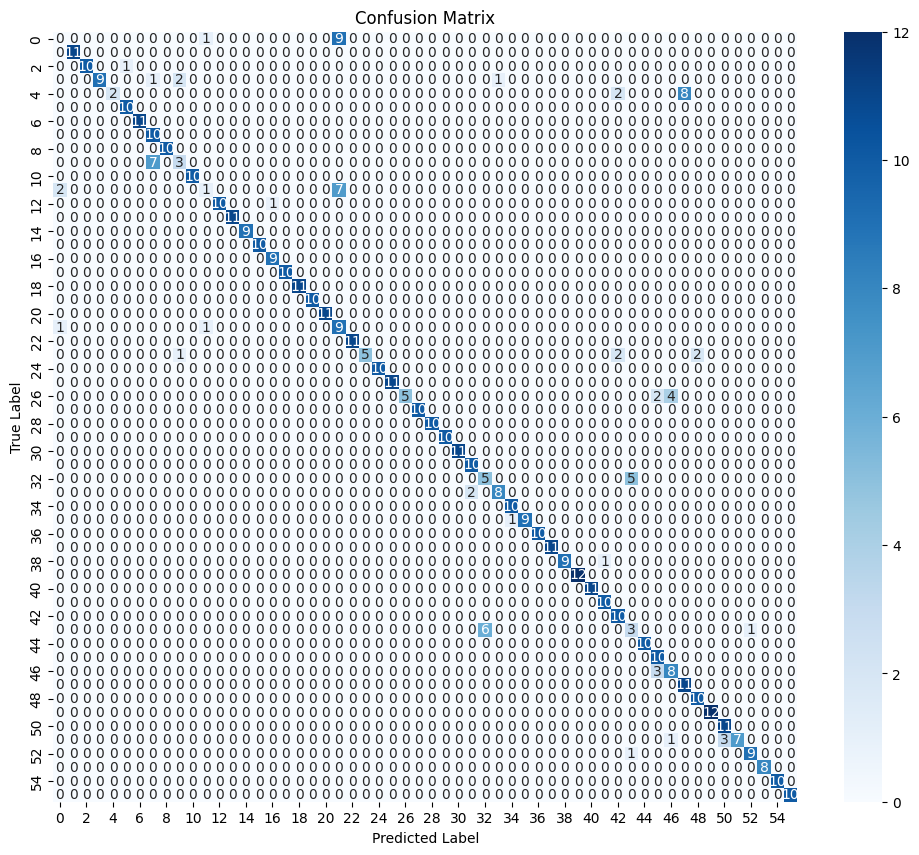

In [79]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [80]:
0.91 - accuracy

0.045506003430531794

In [81]:
from matplotlib import pyplot as plt

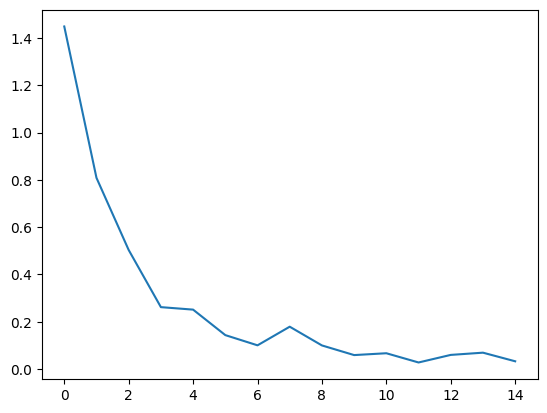

In [82]:
plt.plot(history["loss"])

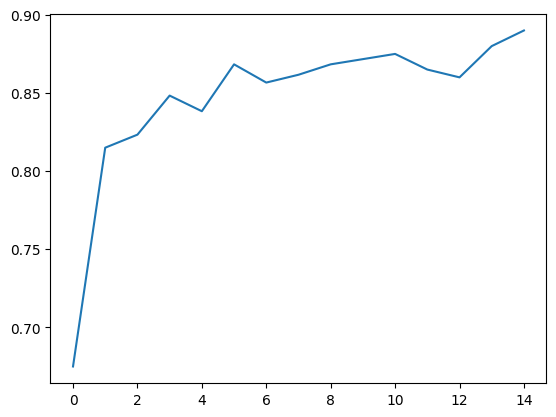

In [83]:
plt.plot(history["accuracy"])